In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!sudo apt-get update && sudo apt-get install ffmpeg

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:4 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Hit:5 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease    
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]      
Hit:7 http://archive.ubuntu.com/ubuntu jammy InRelease                         
Get:8 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [83.4 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]        
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,153 kB]
Get:11 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy/main amd64 Packages [38.5 kB]
Get:12 https://r2u.stat.illi

In [3]:
pip install -U datasets[audio] librosa lightning torch torchvision torchaudio torchlibrosa museval torchcontrib --extra-index-url https://download.pytorch.org/whl/cu126

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu126
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 846.0/846.0 kB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 833.0/833.0 MB 2.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 109.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 86.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.8/706.8 MB 2.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 7.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 1.2 MB/s eta 0:00:000:00:01
   ━━━━━

In [4]:
from datasets import ClassLabel


# Common Configurations
class_names = ["car_horn", "cough", "dog_bark", "gun_shot", "siren"]
CLASSES = ClassLabel(names=class_names)

TARGET_SAMPLING_RATE = 32000

In [13]:
from datasets import Dataset, Features, Value, ClassLabel, Audio
import os


# Load File Dataset

all_data = []

ROOT_DATA_DIRECTORY = "/kaggle/input/dlproject/classification/train"

for root, dirs, files in os.walk(ROOT_DATA_DIRECTORY):
    # 'root' is the current directory path (e.g., '.../train/car_horn')
    
    # Extract the label from the subdirectory name
    # os.path.basename returns the last component of the path (e.g., 'car_horn')
    current_label = os.path.basename(root)
    
    # Only process directories that are actual class folders
    if current_label in class_names:
        print(f"Processing directory: {current_label}")
        
        for file_name in files:
            # Check for common audio extensions
            if file_name.endswith(('.wav', '.mp3', '.flac')):
                # Construct the full file path
                file_path = os.path.join(root, file_name)

                data_record = {
                    "file_path" : file_path,
                    "file_name": file_name,
                    "label": current_label,
                    "onset": 0.0,
                    "offset": 0.0
                }

                all_data.append(data_record)

Processing directory: cough
Processing directory: gun_shot
Processing directory: dog_bark
Processing directory: siren
Processing directory: car_horn


In [14]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

for i, record in tqdm(enumerate(all_data), total=len(all_data), desc="Processing Records"):
    record_file_path = record['file_path']

    audio, sr = librosa.load(record_file_path, sr=None)
    S = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)
    S_dB = librosa.power_to_db(S, ref=np.max)
    duration = librosa.get_duration(y=audio, sr=sr)

    # --- Configuration ---
    HOP_LENGTH = 512 
    FRAME_LENGTH = 2048 
    THRESHOLD_FACTOR = 1.5
    ABSOLUTE_NOISE_THRESHOLD = 0.05
    BOUNDARY_BUFFER_TIME = 0.10
    MAX_RMS_STD_FOR_CONSTANT_CLIP = 0.01
    MAX_ENERGY_RANGE_FOR_CONSTANT_CLIP = 0.01

    # Calculate RMS energy
    rms_energy = librosa.feature.rms(y=audio, frame_length=2048, hop_length=HOP_LENGTH)[0]

    # Determine Threshold
    noise_floor = np.percentile(rms_energy, 10)
    rms_10th = np.percentile(rms_energy, 10)
    rms_90th = np.percentile(rms_energy, 90)
    energy_range = rms_90th - rms_10th

    rms_std_dev = np.std(rms_energy)

    # --- 1. Global Noise Floor Check ---
    if noise_floor >= ABSOLUTE_NOISE_THRESHOLD:
        # ACCEPT ENTIRE CLIP LOGIC
        time_onset = 0.0
        time_offset = duration
        rms_onset_value = np.max(rms_energy)  # Using max for the 'onset' RMS
        rms_offset_value = np.min(rms_energy)  # Using min for the 'offset' RMS
        
        # print(f"🚨 Noise Floor ({noise_floor:.4f}) is above the absolute threshold ({ABSOLUTE_NOISE_THRESHOLD:.4f}).")
        # print(f"➡️ Accepting the entire clip: 0.000 s to {duration:.3f} s")
    elif rms_std_dev <= MAX_RMS_STD_FOR_CONSTANT_CLIP:
        # ACCEPT ENTIRE CLIP LOGIC
        time_onset = 0.0
        time_offset = duration
        rms_onset_value = np.max(rms_energy)
        rms_offset_value = np.min(rms_energy)
        
        # print(f"🚨 RMS Energy distribution is too narrow (Std Dev: {rms_std_dev:.4f}).")
        # print(f"➡️ Accepting the entire clip due to constant loudness.")
    elif energy_range <= MAX_ENERGY_RANGE_FOR_CONSTANT_CLIP:
        # ACCEPT ENTIRE CLIP LOGIC
        time_onset = 0.0
        time_offset = duration
        rms_onset_value = np.max(rms_energy)
        rms_offset_value = np.min(rms_energy)
        
        # print(f"🚨 RMS Energy range ({energy_range:.4f}) is too narrow.")
        # print(f"➡️ Accepting the entire clip due to constant loudness.")
    else:
        # --- 2. Standard Onset/Offset Detection ---
        threshold = noise_floor * THRESHOLD_FACTOR
        onset_frame_indices = np.where(rms_energy > threshold)[0]

        if len(onset_frame_indices) > 0:
            # Initial Detection
            onset_frame = onset_frame_indices[0]
            time_onset = librosa.frames_to_time(onset_frame, sr=sr, hop_length=HOP_LENGTH)
            
            offset_frame = onset_frame_indices[-1]
            time_offset = librosa.frames_to_time(offset_frame, sr=sr, hop_length=HOP_LENGTH)
            
            # # Check if Onset is near the start
            # if time_onset_detected <= BOUNDARY_BUFFER_TIME:
            #     print(f"Onset {time_onset_detected} is near start, setting to start")
            #     time_onset_detected = 0
                
            # # Check if Offset is near the end
            # if time_offset_detected >= (duration - BOUNDARY_BUFFER_TIME):
            #     print(f"Offset {time_offset_detected} is near end, setting to {duration:.2f}")
            #     time_offset_detected = duration
            
        else:
            # Clip is too quiet even for standard detection
            time_onset = 0
            time_offset = duration
            print("Sound event not detected above threshold. Onset/Offset set to full duration.")
        
    record["onset"] = time_onset
    record["offset"] = time_offset

    all_data[i] = record

import pandas as pd

train_df = pd.DataFrame(all_data, columns=["file_path", "file_name", "label", "onset", "offset"])
train_df.to_csv('train_data.csv')
train_df.head(5)

Processing Records: 100%|██████████| 4564/4564 [01:26<00:00, 52.94it/s]


,file_path,file_name,label,onset,offset
0,/kaggle/input/dlproject/classification/train/c...,082d58d7-5ac2-41b9-920f-b48f761d6127.wav,cough,0.106667,8.576000
1,/kaggle/input/dlproject/classification/train/c...,93cb69e1-66e8-44e5-8e9c-a8e58bc48dd2.wav,cough,0.032000,8.330667
2,/kaggle/input/dlproject/classification/train/c...,377d7cc3-9a71-4c12-b985-8b559c055a5a.wav,cough,0.000000,3.120000
3,/kaggle/input/dlproject/classification/train/c...,227aa787-6fa6-467b-b682-9a16508b86f3.wav,cough,1.216000,6.677333
4,/kaggle/input/dlproject/classification/train/c...,173c5141-00ff-4b6a-ba5f-48e376f0790a.wav,cough,0.032000,5.152000


/tmp/ipykernel_76/3503735481.py:32: FutureWarning: waveshow() keyword argument 'x_axis' has been renamed to 'axis' in version 0.10.0.
	This alias will be removed in version 1.0.
  librosa.display.waveshow(audio, sr=sr, x_axis='time', ax=ax[1])


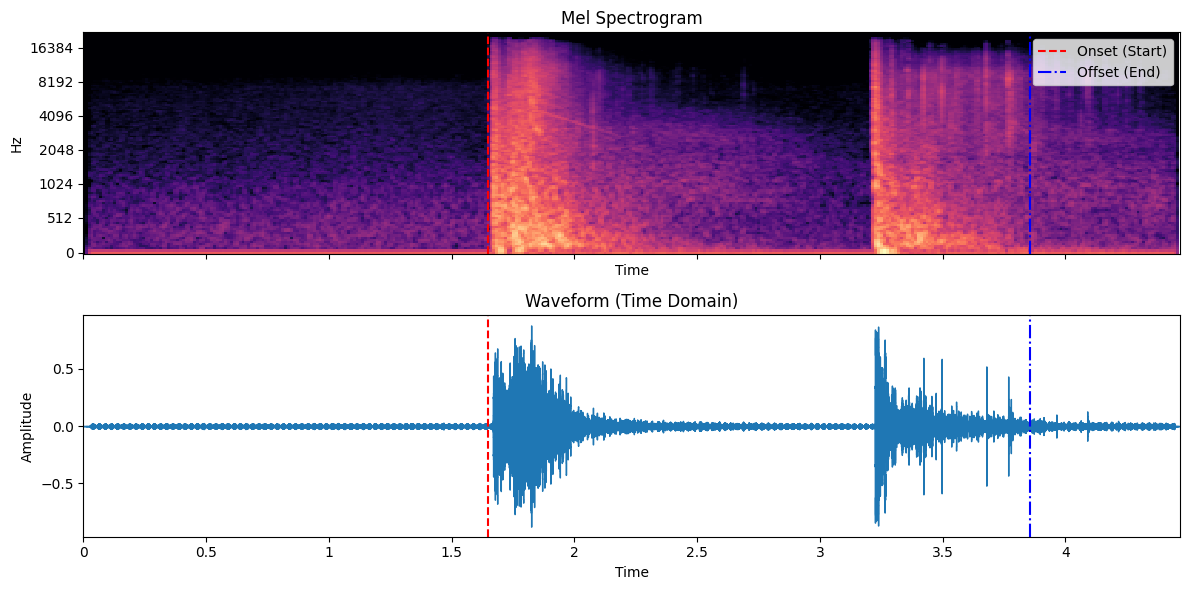

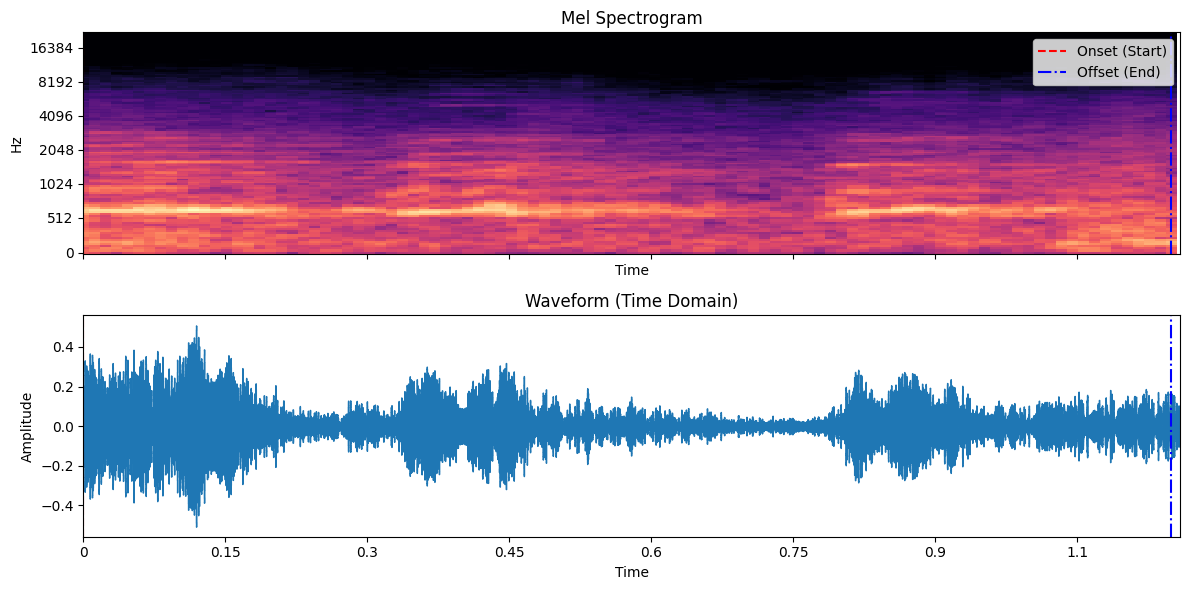

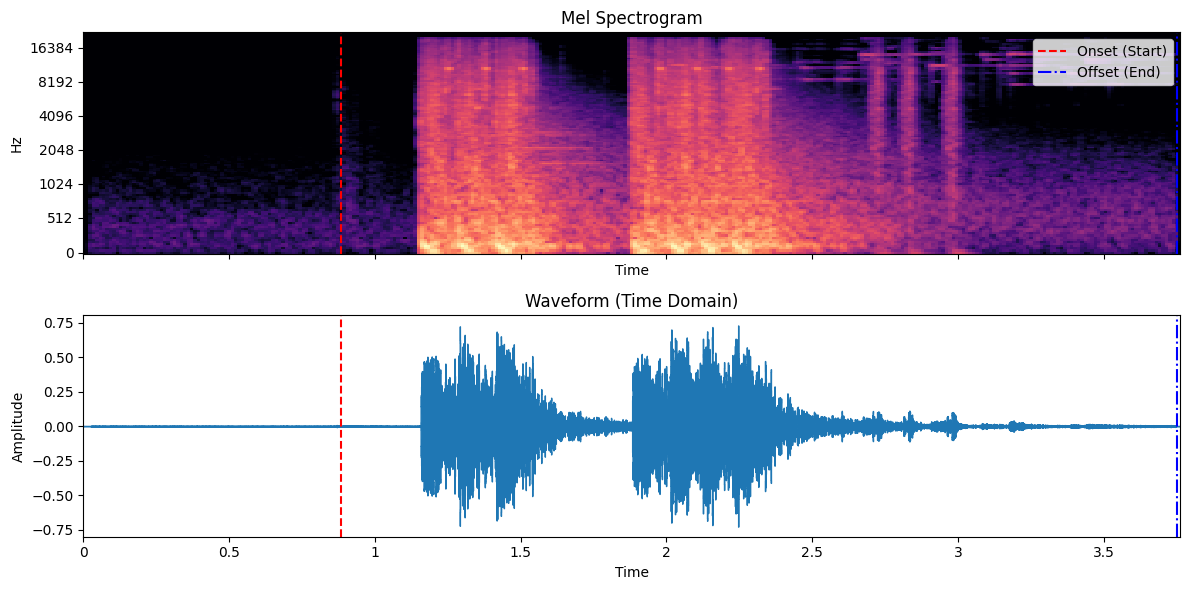

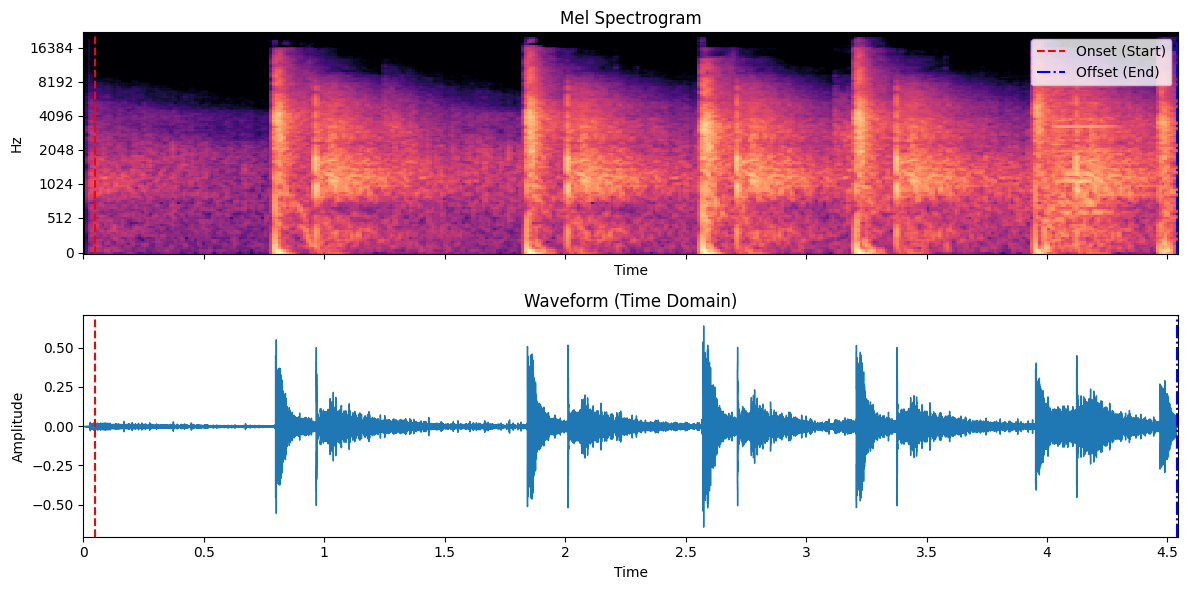

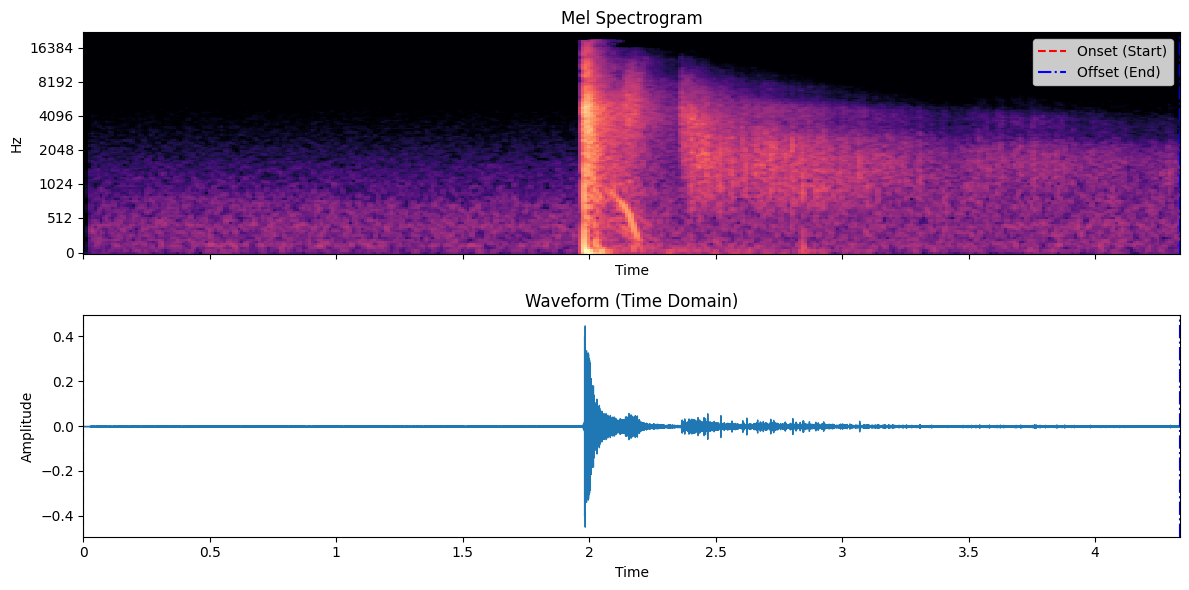

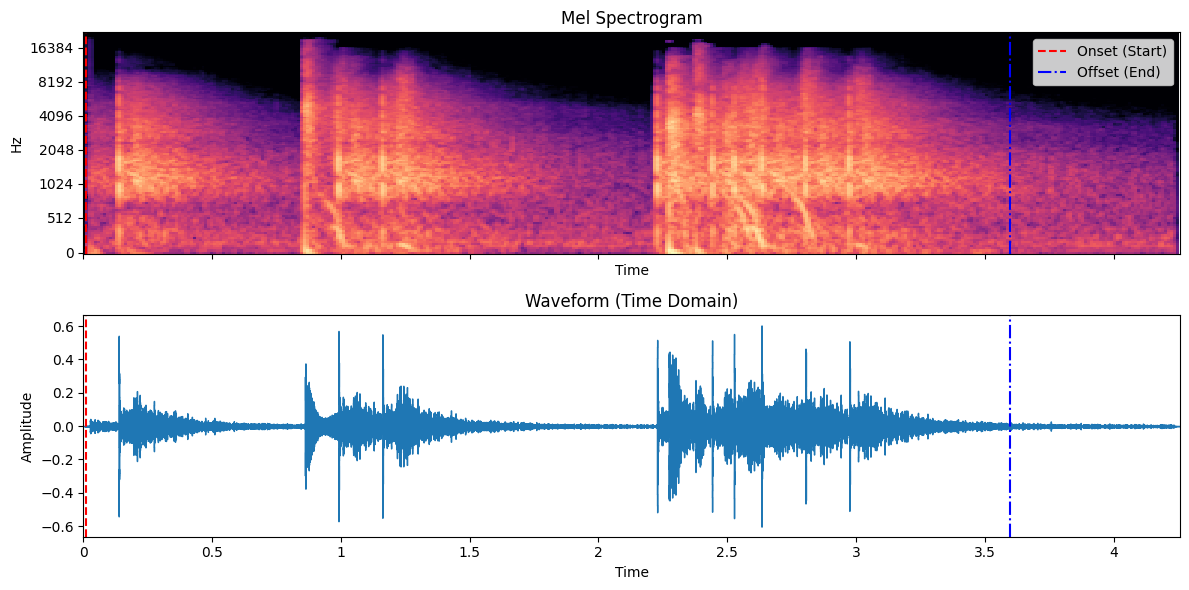

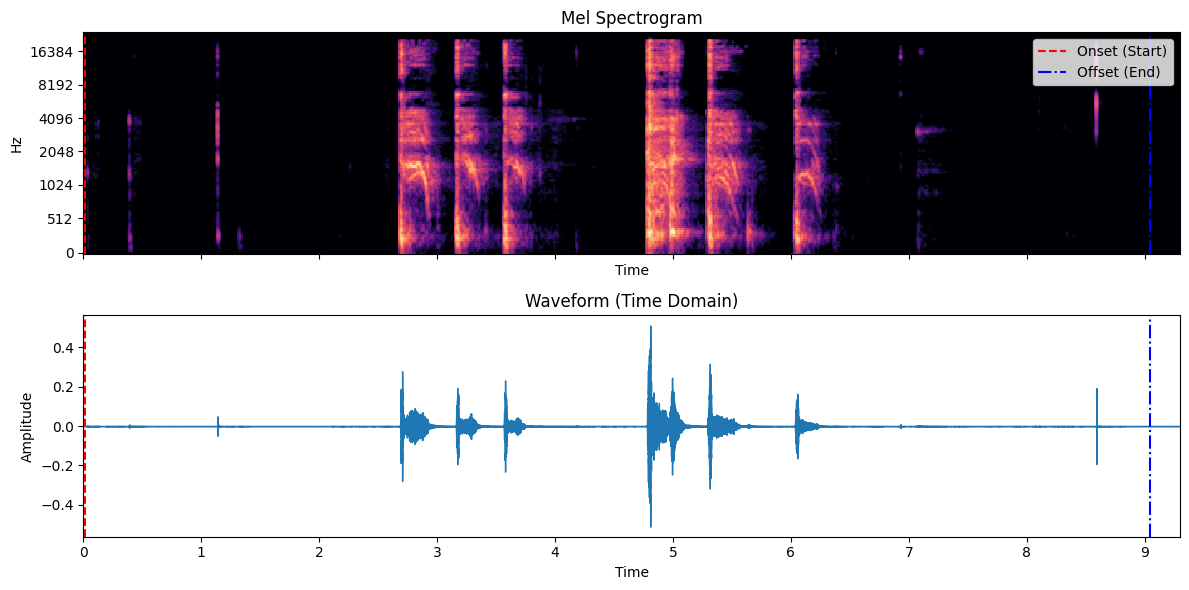

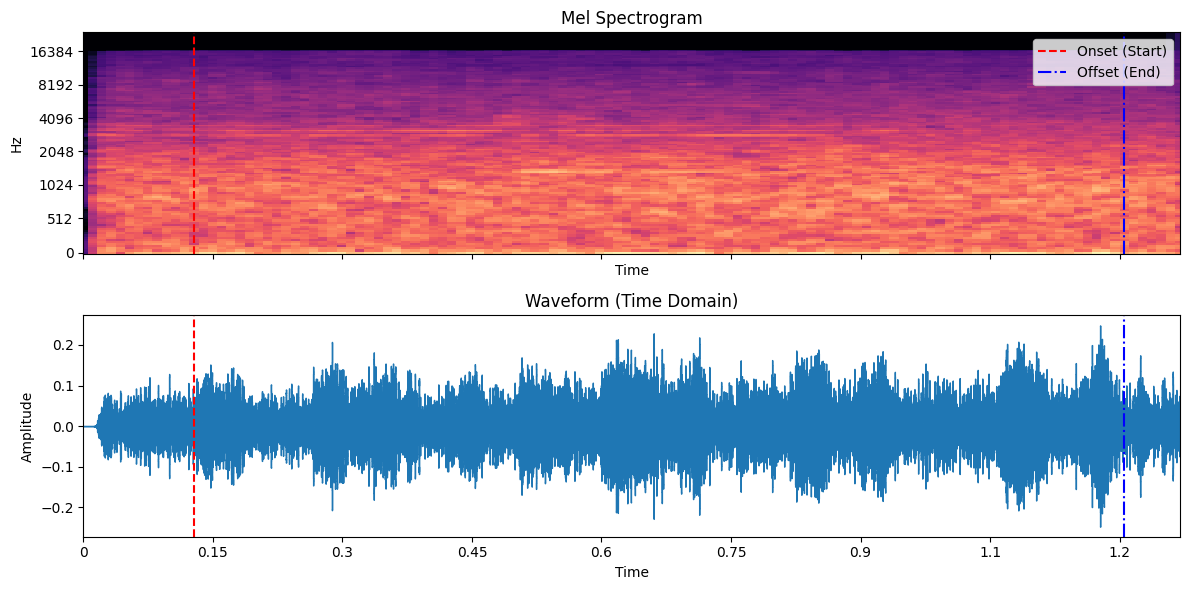

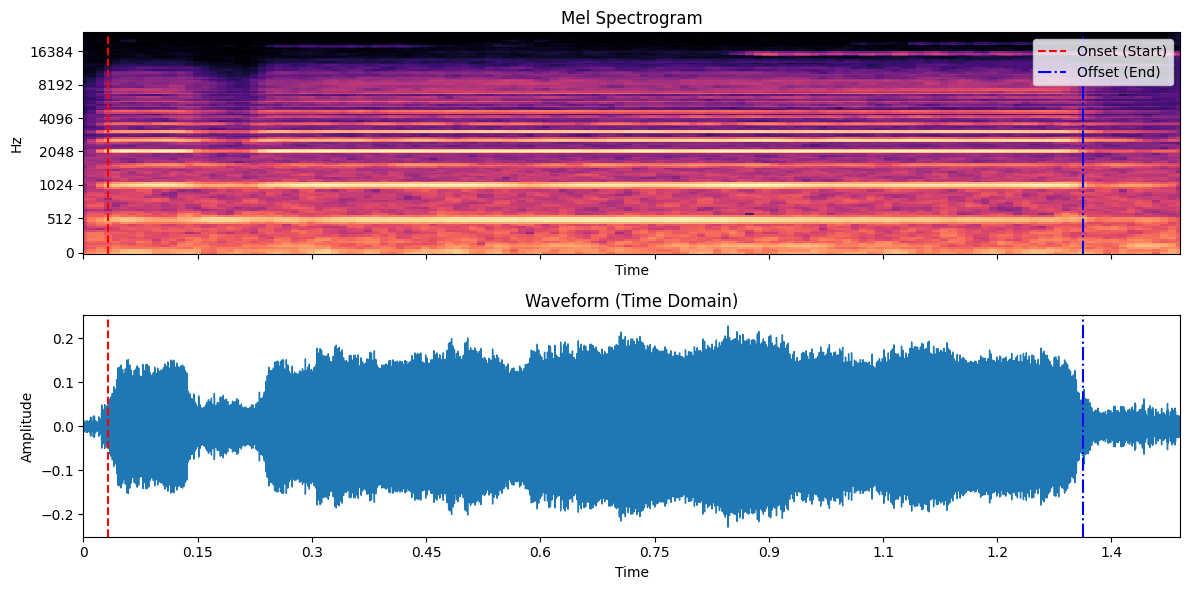

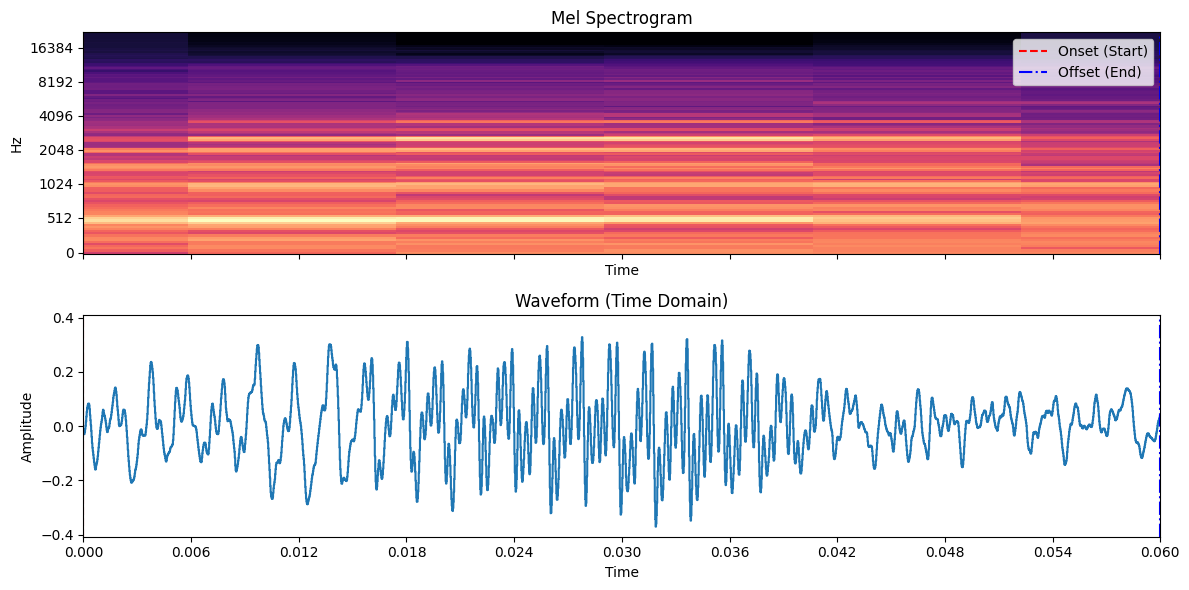

In [17]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import random

for i in range(10):
    SAMPLE_INDEX = random.randint(0, len(all_data))

    record = all_data[SAMPLE_INDEX]
    record_file_path = record['file_path']
    time_onset = record['onset']
    time_offset = record['offset']

    audio, sr = librosa.load(record_file_path, sr=None)
    S = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)
    S_dB = librosa.power_to_db(S, ref=np.max)
    duration = librosa.get_duration(y=audio, sr=sr)

    fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

    # Subplot 1: Mel Spectrogram (ax[0])
    img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, fmax=sr/2, ax=ax[0]) 
    # Add onset line
    ax[0].axvline(time_onset, color='red', linestyle='--', label='Onset (Start)')
    # Add offset line
    ax[0].axvline(time_offset, color='blue', linestyle='-.', label='Offset (End)')
    ax[0].set(title=f'Mel Spectrogram')


    # Subplot 2: Waveform (ax[1])
    librosa.display.waveshow(audio, sr=sr, x_axis='time', ax=ax[1])
    # Add onset line
    ax[1].axvline(time_onset, color='red', linestyle='--', label='Onset (Start)')
    # Add offset line
    ax[1].axvline(time_offset, color='blue', linestyle='-.', label='Offset (End)')
    ax[1].set(title='Waveform (Time Domain)', ylabel='Amplitude')

    ax[0].set_xlim([0, duration])
    ax[1].set_xlim([0, duration])

    ax[0].legend(loc='upper right') 

    plt.tight_layout()
    plt.show()

In [11]:
from datasets import Dataset, Features, Value, ClassLabel, Audio
import os


# Load File Dataset

all_data = []

ROOT_DATA_DIRECTORY = "/kaggle/input/dlproject/classification/test"

for root, dirs, files in os.walk(ROOT_DATA_DIRECTORY):
    # 'root' is the current directory path (e.g., '.../train/car_horn')
    
    # Extract the label from the subdirectory name
    # os.path.basename returns the last component of the path (e.g., 'car_horn')
    current_label = os.path.basename(root)
    
    # Only process directories that are actual class folders
    if current_label in class_names:
        print(f"Processing directory: {current_label}")
        
        for file_name in files:
            # Check for common audio extensions
            if file_name.endswith(('.wav', '.mp3', '.flac')):
                # Construct the full file path
                file_path = os.path.join(root, file_name)

                data_record = {
                    "file_path" : file_path,
                    "file_name": file_name,
                    "label": current_label,
                    "onset": 0.0,
                    "offset": 0.0
                }

                all_data.append(data_record)

Processing directory: cough
Processing directory: gun_shot
Processing directory: dog_bark
Processing directory: siren
Processing directory: car_horn


In [12]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

for i, record in tqdm(enumerate(all_data), total=len(all_data), desc="Processing Records"):
    record_file_path = record['file_path']

    audio, sr = librosa.load(record_file_path, sr=None)
    S = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)
    S_dB = librosa.power_to_db(S, ref=np.max)
    duration = librosa.get_duration(y=audio, sr=sr)

    # --- Configuration ---
    HOP_LENGTH = 512 
    FRAME_LENGTH = 2048 
    THRESHOLD_FACTOR = 1.5
    ABSOLUTE_NOISE_THRESHOLD = 0.05
    BOUNDARY_BUFFER_TIME = 0.10
    MAX_RMS_STD_FOR_CONSTANT_CLIP = 0.01
    MAX_ENERGY_RANGE_FOR_CONSTANT_CLIP = 0.01

    # Calculate RMS energy
    rms_energy = librosa.feature.rms(y=audio, frame_length=2048, hop_length=HOP_LENGTH)[0]

    # Determine Threshold
    noise_floor = np.percentile(rms_energy, 10)
    rms_10th = np.percentile(rms_energy, 10)
    rms_90th = np.percentile(rms_energy, 90)
    energy_range = rms_90th - rms_10th

    rms_std_dev = np.std(rms_energy)

    # --- 1. Global Noise Floor Check ---
    if noise_floor >= ABSOLUTE_NOISE_THRESHOLD:
        # ACCEPT ENTIRE CLIP LOGIC
        time_onset = 0.0
        time_offset = duration
        rms_onset_value = np.max(rms_energy)  # Using max for the 'onset' RMS
        rms_offset_value = np.min(rms_energy)  # Using min for the 'offset' RMS
        
        # print(f"🚨 Noise Floor ({noise_floor:.4f}) is above the absolute threshold ({ABSOLUTE_NOISE_THRESHOLD:.4f}).")
        # print(f"➡️ Accepting the entire clip: 0.000 s to {duration:.3f} s")
    elif rms_std_dev <= MAX_RMS_STD_FOR_CONSTANT_CLIP:
        # ACCEPT ENTIRE CLIP LOGIC
        time_onset = 0.0
        time_offset = duration
        rms_onset_value = np.max(rms_energy)
        rms_offset_value = np.min(rms_energy)
        
        # print(f"🚨 RMS Energy distribution is too narrow (Std Dev: {rms_std_dev:.4f}).")
        # print(f"➡️ Accepting the entire clip due to constant loudness.")
    elif energy_range <= MAX_ENERGY_RANGE_FOR_CONSTANT_CLIP:
        # ACCEPT ENTIRE CLIP LOGIC
        time_onset = 0.0
        time_offset = duration
        rms_onset_value = np.max(rms_energy)
        rms_offset_value = np.min(rms_energy)
        
        # print(f"🚨 RMS Energy range ({energy_range:.4f}) is too narrow.")
        # print(f"➡️ Accepting the entire clip due to constant loudness.")
    else:
        # --- 2. Standard Onset/Offset Detection ---
        threshold = noise_floor * THRESHOLD_FACTOR
        onset_frame_indices = np.where(rms_energy > threshold)[0]

        if len(onset_frame_indices) > 0:
            # Initial Detection
            onset_frame = onset_frame_indices[0]
            time_onset = librosa.frames_to_time(onset_frame, sr=sr, hop_length=HOP_LENGTH)
            
            offset_frame = onset_frame_indices[-1]
            time_offset = librosa.frames_to_time(offset_frame, sr=sr, hop_length=HOP_LENGTH)
            
            # # Check if Onset is near the start
            # if time_onset_detected <= BOUNDARY_BUFFER_TIME:
            #     print(f"Onset {time_onset_detected} is near start, setting to start")
            #     time_onset_detected = 0
                
            # # Check if Offset is near the end
            # if time_offset_detected >= (duration - BOUNDARY_BUFFER_TIME):
            #     print(f"Offset {time_offset_detected} is near end, setting to {duration:.2f}")
            #     time_offset_detected = duration
            
        else:
            # Clip is too quiet even for standard detection
            time_onset = 0
            time_offset = duration
            print("Sound event not detected above threshold. Onset/Offset set to full duration.")
        
    record["onset"] = time_onset
    record["offset"] = time_offset

    all_data[i] = record

import pandas as pd

train_df = pd.DataFrame(all_data, columns=["file_path", "file_name", "label", "onset", "offset"])
train_df.to_csv('test_data.csv')
train_df.head(5)

Processing Records: 100%|██████████| 1141/1141 [00:37<00:00, 30.39it/s]


,file_path,file_name,label,onset,offset
0,/kaggle/input/dlproject/classification/test/co...,144b04ae-6c59-4b80-b024-3a16b6407c06.wav,cough,0.010667,3.776000
1,/kaggle/input/dlproject/classification/test/co...,086ab51f-8057-4c99-b450-1cdf69ae2572.wav,cough,0.053333,9.834667
2,/kaggle/input/dlproject/classification/test/co...,93a49de4-abfb-4d83-9504-4cdc6028d98c.wav,cough,0.000000,9.960000
3,/kaggle/input/dlproject/classification/test/co...,348ff399-d9c1-445e-aeac-15595e688346.wav,cough,0.117333,4.266667
4,/kaggle/input/dlproject/classification/test/co...,313dc757-bd3a-430f-9de2-545298b4b2a1.wav,cough,0.042667,9.952000
